## Felles import for alle kodeblokker

In [1]:
import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from dash import Dash, html, dcc, Input, Output, callback, no_update
import calendar

import sys
sys.path.append("../analysis")
from yearly_stats import YearlyStats
from outlier_analysis import OutlierAnalysis
from outlier_detector import OutlierDetector
from monthly_stats import MonthlyStats
from base_data import DataLoader 

loader = DataLoader("../../data/processed")
ms = MonthlyStats("../../data/processed")
ys = YearlyStats("../../data/processed")
oa = OutlierAnalysis("../../data/processed")
od = OutlierDetector()

sys.path.append("../missingData")
from missingdatafinder import MissingDataConverter

missing = MissingDataConverter()

## Totalt nedbørsmengde per år

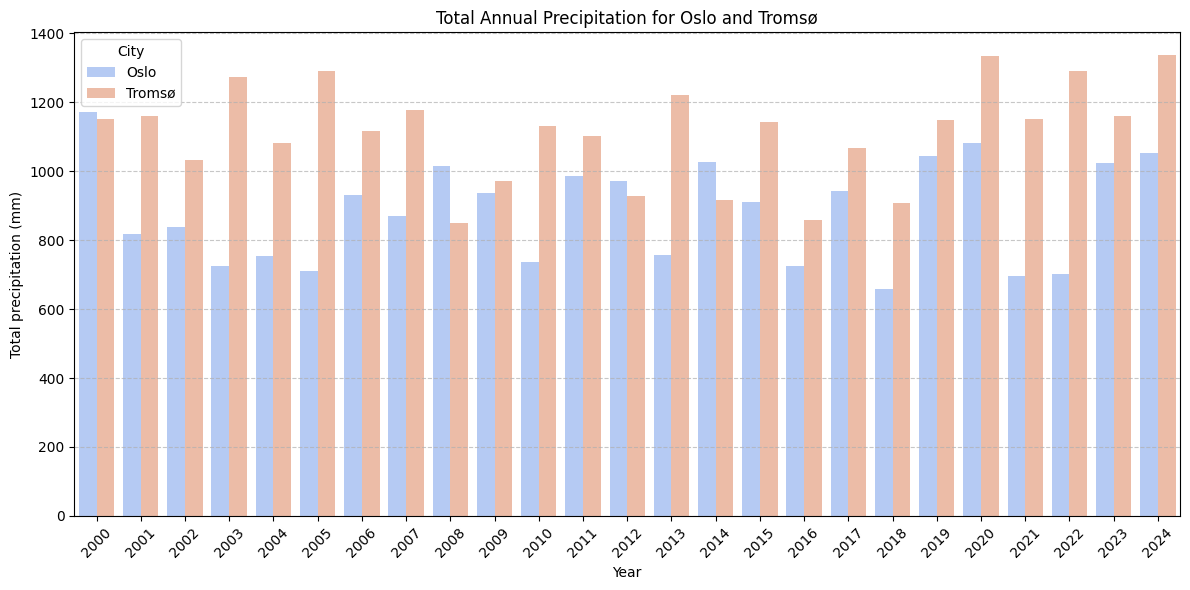

In [2]:
# Hjelpefunksjon for å lage en DataFrame med årlig nedbør for en by
def yearly_precip(city: str, city_label: str) -> pd.DataFrame:
    df = ys.compute_yearly(
        city=city,
        element_id="sum(precipitation_amount P1D)",
        aggregate="sum"
    )
    df["city"] = city_label
    return df

annual_precip = pd.concat([
    yearly_precip("oslo",   "Oslo"),
    yearly_precip("tromso", "Tromsø"),
], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=annual_precip,
    x="year", y="value", hue="city",
    palette="coolwarm"
)
plt.title("Total Annual Precipitation for Oslo and Tromsø")
plt.xlabel("Year")
plt.ylabel("Total precipitation (mm)")
plt.xticks(rotation=45)
plt.legend(title="City")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Tempratur forskjell by

In [3]:
# Hent ferdigberegnet temperaturspenn (range) for begge byer
df_oslo = ms.compute_all_months("range(air_temperature P1D)", "oslo",)
df_tromso = ms.compute_all_months("range(air_temperature P1D)", "tromso",)

# Legg til 'year' og 'month'-kolonner
for df in [df_oslo, df_tromso]:
    df["year_month"] = pd.to_datetime(df["year_month"])
    df["year"] = df["year_month"].dt.year
    df["month"] = df["year_month"].dt.month_name()
    df["temp_diff"] = df["mean"]  # Gi nytt navn for bruk i figuren

# Start Dash-app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Temperature Range (Difference) per Month"),
    html.Label("City:"),
    dcc.Dropdown(
        id='city-dropdown',
        options=[{'label': 'Oslo', 'value': 'Oslo'}, {'label': 'Tromsø', 'value': 'Tromsø'}],
        value='Oslo'
    ),
    html.Label("Month:"),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': m, 'value': m} for m in calendar.month_name[1:]],
        value='January'
    ),
    html.Label("Start Year:"),
    dcc.Input(id='start-year', type='number', value=2000, min=2000, max=2023),
    html.Label("End Year:"),
    dcc.Input(id='end-year', type='number', value=2023, min=2000, max=2023),
    dcc.Graph(id='temperature-graph')
])

@app.callback(
    Output('temperature-graph', 'figure'),
    Input('city-dropdown', 'value'),
    Input('month-dropdown', 'value'),
    Input('start-year', 'value'),
    Input('end-year', 'value')
)
def update_graph(city, month, start_year, end_year):
    if city == "Oslo":
        df_filtered = df_oslo[
            (df_oslo["year"] >= start_year) &
            (df_oslo["year"] <= end_year) &
            (df_oslo["month"] == month)
        ]
    elif city == "Tromsø":
        df_filtered = df_tromso[
            (df_tromso["year"] >= start_year) &
            (df_tromso["year"] <= end_year) &
            (df_tromso["month"] == month)
        ]
    else:
        return px.bar(title="No Data Available")

    fig = px.bar(
        df_filtered,
        x="year",
        y="temp_diff",
        color="temp_diff",
        color_continuous_scale="YlOrRd",
        title=f"Average Temperature Range for {month} – {city} ({start_year} to {end_year})",
        labels={"temp_diff": "Temp. Range (°C)", "year": "Year"}
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8052)

## Manglende verdier

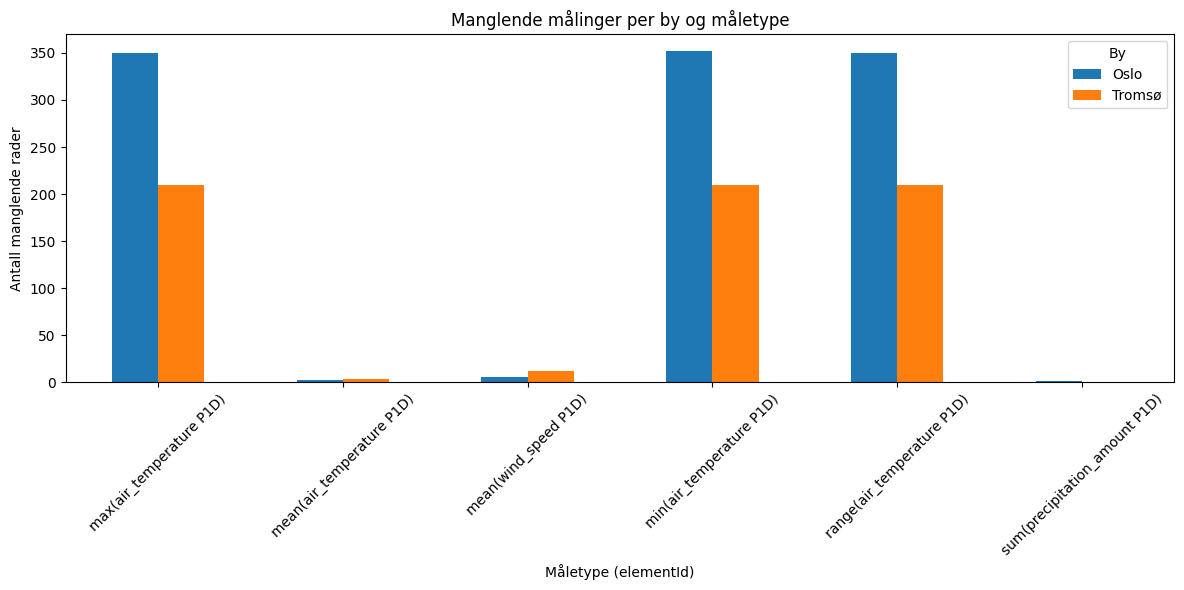

In [4]:
df_missing = missing.read_missing_values("../../data/missing/missing_in_both.csv")

df_missing.columns = df_missing.columns.str.strip()
df_missing["elementId"] = df_missing["elementId"].astype(str).str.strip()
df_missing["missing"] = df_missing["missing"].astype(str).str.strip()

df_summary = (
    df_missing.groupby(["missing", "elementId"])
    .size()
    .reset_index(name="num_missing")
    .rename(columns={"missing": "city"})
)

pivoted = df_summary.pivot(index="elementId", columns="city", values="num_missing").fillna(0)

pivoted.plot(kind="bar", figsize=(12, 6))
plt.title("Manglende målinger per by og måletype")
plt.xlabel("Måletype (elementId)")
plt.ylabel("Antall manglende rader")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()

## Interaktiv versjon for visning av manglende data

In [5]:
df_raw = missing.read_missing_values("../../data/missing/missing_in_both.csv")

df_raw.columns = df_raw.columns.str.strip()
df_raw["elementId"] = df_raw["elementId"].astype(str).str.strip()
df_raw["missing"] = df_raw["missing"].astype(str).str.strip()

df_missing = (
    df_raw.groupby(["missing", "elementId"])
    .size()
    .reset_index(name="num_missing")
    .rename(columns={"missing": "city"})
)

app = Dash(__name__)

elements = sorted(df_missing["elementId"].unique())
cities = sorted(df_missing["city"].unique())

app.layout = html.Div([
    html.H1("Manglende Værdata per By og Måletype"),

    html.Label("Måletype:"),
    dcc.Dropdown(
        id="element-dropdown",
        options=[{"label": e, "value": e} for e in elements],
        value=elements[0]
    ),

    html.Label("By(er):"),
    dcc.Checklist(
        id="city-checklist",
        options=[{"label": c, "value": c} for c in cities],
        value=cities,
        labelStyle={"display": "inline-block", "margin-right": "10px"}
    ),

    dcc.Graph(id="missing-graph")
])

@app.callback(
    Output("missing-graph", "figure"),
    Input("element-dropdown", "value"),
    Input("city-checklist", "value")
)
def update_graph(elementId, selected_cities):
    filtered = df_missing[
        (df_missing["elementId"] == elementId) &
        (df_missing["city"].isin(selected_cities))
    ]

    fig = px.bar(
        filtered,
        x="city",
        y="num_missing",
        color="city",
        title=f"Manglende målinger for '{elementId}'",
        labels={"num_missing": "Antall manglende målinger", "city": "By"},
        text="num_missing"
    )
    fig.update_layout(template="plotly_white")
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8053)


## Gjennomsnittlig vindhastighet per måned

In [6]:
# 1. Hent gjennomsnitt per måned for Oslo og Tromsø for vind
oslo_df = ms.compute_all_months("mean(wind_speed P1D)", "Oslo",)

tromso_df = ms.compute_all_months("mean(wind_speed P1D)", "tromso",)

# 2. Konverter 'year_month' til datetime for plotting
oslo_df["year_month"] = pd.to_datetime(oslo_df["year_month"])
tromso_df["year_month"] = pd.to_datetime(tromso_df["year_month"])

# 3. Lag graf med Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=oslo_df["year_month"],
    y=oslo_df["mean"],
    mode="lines+markers",
    name="Oslo",
    line=dict(color="blue"),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=tromso_df["year_month"],
    y=tromso_df["mean"],
    mode="lines+markers",
    name="Tromsø",
    line=dict(color="red"),
    marker=dict(size=6)
))

fig.update_layout(
    title="Gjennomsnittlig vindhastighet per måned i Oslo og Tromsø",
    xaxis_title="Tid",
    yaxis_title="Vindhastighet (m/s)",
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

## Antall sommerdager per år

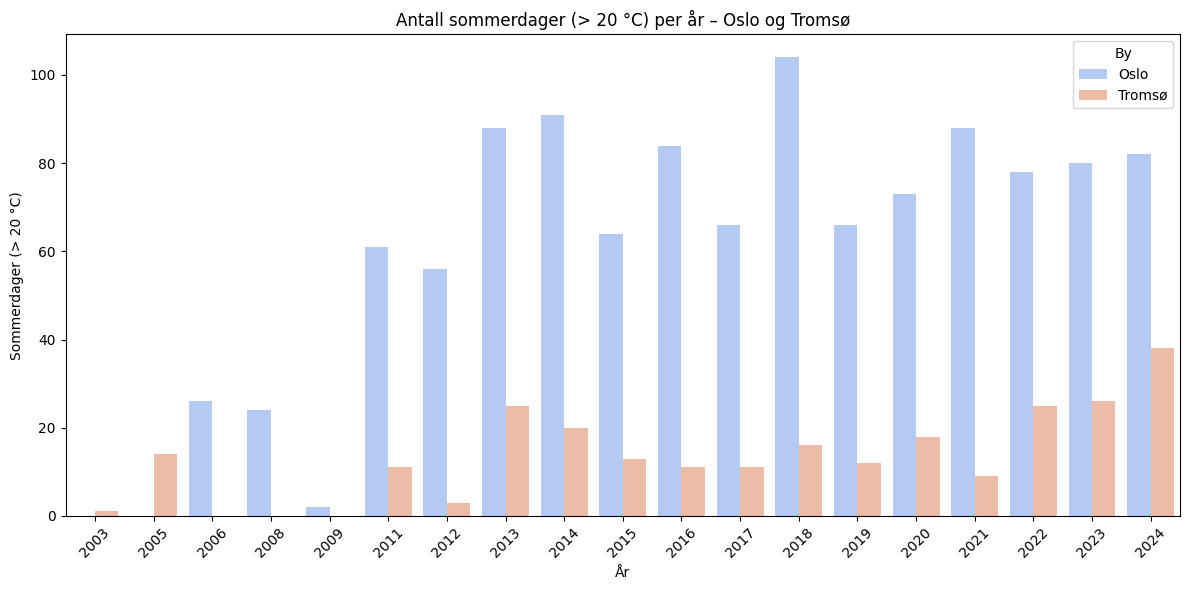

In [7]:
def summer_days_per_year(
        city: str,
        city_name: str,
        *,
        threshold: float = 20.0
    ) -> pd.DataFrame:
    element_id = "max(air_temperature P1D)"
    offset = loader._get_min_offset(city, element_id) 

    df = (
        loader._load_city(city)
        .query("elementId == @element_id and timeOffset == @offset")
        .copy()
    )
    df["referenceTime"] = pd.to_datetime(df["referenceTime"], utc=True)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    df["year"] = df["referenceTime"].dt.year
    mask = df["value"] > threshold
    out = (
        df.loc[mask]
        .groupby("year")
        .size()
        .reset_index(name="summer_days")
    )
    out["city"] = city_name
    return out
summer_days_df = pd.concat(
    [
        summer_days_per_year("oslo",   "Oslo"),
        summer_days_per_year("tromso", "Tromsø"),
    ],
    ignore_index=True
)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summer_days_df,
    x="year", y="summer_days",
    hue="city",       
    palette="coolwarm"
)
plt.title("Antall sommerdager (> 20 °C) per år – Oslo og Tromsø")
plt.xlabel("År")
plt.ylabel("Sommerdager (> 20 °C)")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()


## Interaktiv versjon for visning av antall ekstrem verdier

In [8]:
cities = ["oslo", "tromso"]
element_ids = [
    "mean(air_temperature P1D)",
    "mean(wind_speed P1D)",
    "max(air_temperature P1D)",
    "min(air_temperature P1D)",
    "range(air_temperature P1D)",
    "sum(precipitation_amount P1D)"
]

app = Dash(__name__)
app.title = "Outlier‑visualisering"

app.layout = html.Div(
    style={"maxWidth": "900px", "margin": "auto"},
    children=[
        html.H1("Ekstremverdier (Outliers) per måned"),

        html.Label("By:"),
        dcc.Dropdown(
            id="city-dropdown",
            options=[{"label": c.capitalize(), "value": c} for c in cities],
            value=cities[0],
            clearable=False,
        ),

        html.Label("Måletype (elementId):"),
        dcc.Dropdown(
            id="element-dropdown",
            options=[{"label": e, "value": e} for e in element_ids],
            value="sum(precipitation_amount P1D)",
            clearable=False,
        ),

        html.Label("Vis måneder uten outliers:"),
        dcc.Checklist(
            id="toggle-empty-months",
            options=[{"label": "Ja", "value": "vis"}],
            value=["vis"],
            inline=True,
        ),

        dcc.Graph(id="outlier-graph"),
    ],
)
@app.callback(
    Output("outlier-graph", "figure"),
    Input("city-dropdown", "value"),
    Input("element-dropdown", "value"),
    Input("toggle-empty-months", "value"),
)
def update_outlier_graph(city, element_id, show_empty_months):
    """Oppdater grafen når brukeren endrer valg."""
    vis_tomme = "vis" in show_empty_months

    offset = loader._get_min_offset(city, element_id)

    df_outliers = oa.find_outliers_per_month(
        city,
        element_id,
        time_offset=offset,
        include_empty_months=vis_tomme,
    )

    df_outliers["year_month"] = pd.to_datetime(df_outliers["year_month"])
    df_outliers["måned"] = df_outliers["year_month"].dt.strftime("%b %Y")

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_outliers["måned"],
            y=df_outliers["outliers_removed"],
            name="Antall outliers",
            mode="lines+markers",
            marker=dict(size=6),
            line=dict(color="firebrick"),
        )
    )

    fig.update_layout(
        title=f"Antall outliers per måned – {element_id} i {city.capitalize()} (Offset {offset})",
        xaxis=dict(title="Måned", tickangle=45),
        yaxis=dict(title="Antall outliers"),
        template="plotly_white",
    )
    return fig

if __name__ == "__main__":
    app.run(debug=True, port=8054)
